In [4]:
import os
import glob
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns 
import pybedtools as pbt
import numpy as np
from scipy.stats import mannwhitneyu
from collections import namedtuple

sns.set_theme(style="whitegrid")

pd.options.display.max_rows = 200

os.chdir('/mnt/BioAdHoc/Groups/vd-ay/jreyna/projects/Loop-Catalog-SGLs/')

outdir = 'results/hg38/finemapping/sgls_summary/'
os.makedirs(outdir, exist_ok=True)

pbt.set_bedtools_path('/mnt/bioapps/bedtools/bin/')

#### Adding gene information

In [5]:
old_fn = 'results/hg38/refs/gencode/v30/gencode.v30.annotation.w_genetypes.bed'
fn = 'results/hg38/refs/gencode/v30/gencode.v30.annotation.genes_only.bed.gz'
gencode_df = pd.read_table(fn, header=None)
gencode_df = gencode_df.iloc[:, [0,1,2,5,6,7,8]]
gencode_df.columns =['chrom', 'start', 'end', 'strand', 'genename', 'geneid', 'genetype']
# gencode_df = gencode_df.loc[gencode_df.type == 'gene'].drop('type', axis=1)
gencode_df.loc[:,'geneid'] = gencode_df.loc[:,'geneid'].str.replace('\.[0-9]*', '', regex=True)

<>:7: SyntaxWarning: invalid escape sequence '\.'
<>:7: SyntaxWarning: invalid escape sequence '\.'
/mnt/BioHome/jreyna/tmp/ipykernel_3760992/3830488000.py:7: SyntaxWarning: invalid escape sequence '\.'
  gencode_df.loc[:,'geneid'] = gencode_df.loc[:,'geneid'].str.replace('\.[0-9]*', '', regex=True)


In [6]:
gencode_df

,chrom,start,end,strand,genename,geneid,genetype
0,chr1,11868,14409,+,DDX11L1,ENSG00000223972,transcribed_unprocessed_pseudogene
1,chr1,14403,29570,-,WASH7P,ENSG00000227232,unprocessed_pseudogene
2,chr1,17368,17436,-,MIR6859-1,ENSG00000278267,miRNA
3,chr1,29553,31109,+,MIR1302-2HG,ENSG00000243485,lincRNA
4,chr1,30365,30503,+,MIR1302-2,ENSG00000284332,miRNA
...,...,...,...,...,...,...,...
58865,chrY,57184100,57197337,+,IL9R,ENSG00000124334_PAR_Y,protein_coding
58866,chrY,57190737,57208756,+,AJ271736.1,ENSG00000270726_PAR_Y,processed_transcript
58867,chrY,57201142,57203357,-,WASIR1,ENSG00000185203_PAR_Y,antisense
58868,chrY,57207345,57212230,+,WASH6P,ENSG00000182484_PAR_Y,transcribed_unprocessed_pseudogene


## Load all SGL Data


In [7]:
#fns = glob.glob('results/hg38/finemapping/sgls/*/Naive_B_1814-RH-1.phs001703v3p1.Homo_Sapiens.H3K27ac.b1.5000.finemap_sgls.tsv')
fns = glob.glob('results/hg38/finemapping/sgls/*/*.finemap_sgls.tsv')

# # removing all donors for this analysis
# fns = [x for x in fns if 'All-Donors' not in x]

# # removign all biorep donors from this analysis
# fns = [x for x in fns if 'biorep_merged' not in x]

In [8]:
all_data = []
for fn in fns:
    
    # split meta information
    info = fn.split('/')
    genome = info[1]
    causaldb_fn = info[4]
    sample = info[5].rsplit('.', maxsplit=3)[0]

    # load sgl table
    tdf = pd.read_table(fn)
    tdf.loc[:, 'causaldb_fn'] = causaldb_fn
    tdf.loc[:, 'sample'] = sample

    # append to all
    all_data.append(tdf)

all_df = pd.concat(all_data)
all_df.rename(columns={'-log10_qval': '-log10_qval_loop'}, inplace=True)

In [9]:
all_df.head(3)

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,chrom,start_snp,end_snp,...,label,causaldb_fn,snp_anchor,chr_gene,start_gene,end_gene,genename,geneid,strand,sample
0,12,111405000,111410000,12,111445000,111450000,10.659531,12,111446803,111446804,...,7.0,CA266,AnchorB,12,111405947,111405948,SH2B3,ENSG00000111252,+,Monocyte_1800-RH-1.phs001703v3p1.Homo_Sapiens....
1,16,28490000,28495000,16,28535000,28540000,19.021164,16,28494338,28494339,...,7.0,CA266,AnchorA,16,28539173,28539174,NUPR1,ENSG00000176046,-,Monocyte_1800-RH-1.phs001703v3p1.Homo_Sapiens....
2,16,28490000,28495000,16,28545000,28550000,4.784789,16,28494338,28494339,...,7.0,CA266,AnchorA,16,28548657,28548658,AC020765.1,ENSG00000271495,-,Monocyte_1800-RH-1.phs001703v3p1.Homo_Sapiens....


In [10]:
# load meta information
#causal_metadata_fn = 'workflow/scripts/finemap_sgls/causal_db/init.gwas_study.causal_db.immune_select_samples.tsv'
causal_metadata_fn = 'results/samplesheets/causal_db_sgls/gwas_study.causal_db.immune_select_studies.tsv'
causal_metadata = pd.read_table(causal_metadata_fn, header=None)

# merge meta data
causal_metadata_mapper =  causal_metadata.iloc[:, [2, 8, 18]]
causal_metadata_mapper.columns = ['mesh_term', 'author', 'filename']
all_df = all_df.merge(causal_metadata_mapper, left_on='causaldb_fn', right_on='filename')

# add snp position
all_df['snp_pos'] = all_df['chrom'].astype(str) + ':' + all_df['end_snp'].astype(str)

In [11]:
all_df.head()

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,chrom,start_snp,end_snp,...,start_gene,end_gene,genename,geneid,strand,sample,mesh_term,author,filename,snp_pos
0,12,111405000,111410000,12,111445000,111450000,10.659531,12,111446803,111446804,...,111405947,111405948,SH2B3,ENSG00000111252,+,Monocyte_1800-RH-1.phs001703v3p1.Homo_Sapiens....,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,12:111446804
1,16,28490000,28495000,16,28535000,28540000,19.021164,16,28494338,28494339,...,28539173,28539174,NUPR1,ENSG00000176046,-,Monocyte_1800-RH-1.phs001703v3p1.Homo_Sapiens....,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,16:28494339
2,16,28490000,28495000,16,28545000,28550000,4.784789,16,28494338,28494339,...,28548657,28548658,AC020765.1,ENSG00000271495,-,Monocyte_1800-RH-1.phs001703v3p1.Homo_Sapiens....,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,16:28494339
3,16,28490000,28495000,16,28550000,28555000,23.702902,16,28494338,28494339,...,28553914,28553915,SGF29,ENSG00000176476,+,Monocyte_1800-RH-1.phs001703v3p1.Homo_Sapiens....,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,16:28494339
4,16,28490000,28495000,16,28550000,28555000,23.702902,16,28494338,28494339,...,28554139,28554140,AC020765.2,ENSG00000275441,-,Monocyte_1800-RH-1.phs001703v3p1.Homo_Sapiens....,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,16:28494339


#### Mini-summary

In [12]:
t = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid', 'mesh_term'])
t.shape

(25440, 37)

In [13]:
t = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid', 'sample'])
t.shape

(131983, 37)

In [14]:
# count the samples
num_samples = all_df['sample'].nunique()
print('Number of samples with SGLs:', num_samples)

# count the total number of sgl events across all studies
print('Number of SGL events:', all_df.shape[0]) 

# count the unique snps
num_uniq_snps = (all_df['chrA_loop'].astype(str) + '-' + all_df['end_snp'].astype(str)).nunique()
print('Number of unique snps:', num_uniq_snps)

# count the unique genes
num_uniq_genes = all_df.geneid.nunique()
print('Number of unique genes:', num_uniq_genes)

# count the unique loops
uniq_loops_df = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop'])
print('Number of unique loops:', uniq_loops_df.shape[0])

# count the total number of sgls
uniq_sgls_df = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid'])
print('Number of unique sgls:', uniq_sgls_df.shape[0])

Number of samples with SGLs: 72
Number of SGL events: 163385
Number of unique snps: 3932
Number of unique genes: 2209
Number of unique loops: 6472
Number of unique sgls: 25094


Also want to look at the number of SNPs we started with

In [15]:
num_snps_study = pd.read_table('results/hg38/finemapping/snps/singles/num_snps.tsv', header=None)
num_snps_study.columns = ['num_snps', 'filename']
num_snps_study = num_snps_study.merge(causal_metadata_mapper)
num_snps_study_mesh = num_snps_study.groupby('mesh_term').sum()
num_snps_study_mesh

,num_snps,filename,author
mesh_term,,,
"Arthritis, Rheumatoid",1121,AT452AT454AT551BE151CA104CA391PH378,Roslin InstituteRoslin InstituteRoslin Institu...
"Dermatitis, Atopic",674,GD09159,Sliz E
"Diabetes Mellitus, Type 1",7729,AT280CA265CA266GD08996GD09063GD09519GD09657,Roslin InstituteOnengut Gumuscu SOnengut Gumus...
Psoriasis,590,AT258AT548GD09415,Roslin InstituteRoslin InstituteTsoi LC


Looking into the average distance

In [16]:
dist = (all_df.startB_loop - all_df.startA_loop)

In [17]:
dist.describe().astype(int)

count     163385
mean      376128
std       507234
min        20000
25%        60000
50%       145000
75%       405000
max      2000000
dtype: int64

<Axes: ylabel='Frequency'>

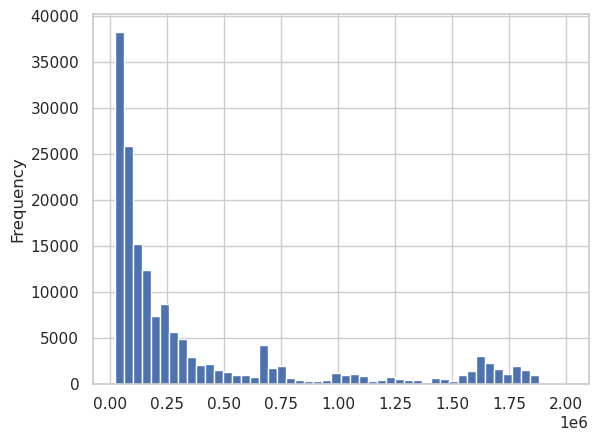

In [18]:
dist.plot(kind='hist', bins=50)

## Overview of SGLs Across Each Disease

### Count the number of sgls per GWAS Study

I would expect that, in general, that studies with more snps will have more SGLs.

In [19]:
grps = all_df.groupby(['causaldb_fn', 'mesh_term', 'author'])
counts = grps['chrA_loop'].count().to_frame()
counts.columns = ['num_sgls']

In [20]:
counts.sort_values(['mesh_term', 'num_sgls'], ascending=[True, False])

,,,num_sgls
causaldb_fn,mesh_term,author,
PH378,"Arthritis, Rheumatoid",Okada Y,15557
AT452,"Arthritis, Rheumatoid",Roslin Institute,7042
AT551,"Arthritis, Rheumatoid",Roslin Institute,4735
CA104,"Arthritis, Rheumatoid",Eyre S,4396
CA391,"Arthritis, Rheumatoid",Stahl EA,1198
BE151,"Arthritis, Rheumatoid",Nealelab,861
AT454,"Arthritis, Rheumatoid",Roslin Institute,476
GD09159,"Dermatitis, Atopic",Sliz E,12948
GD08996,"Diabetes Mellitus, Type 1",Chiou J,31237


In [21]:
counts.describe()

,num_sgls
count,18.000000
mean,9076.944444
std,9036.744862
min,476.000000
25%,3238.750000
50%,7039.500000
75%,12092.000000
max,31237.000000


### Count and plot the number of sgls, snps and genes per mesh term

In [22]:
uniq_sgls_mesh_df = all_df.drop_duplicates(subset=['chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'snp_pos', 'geneid', 'mesh_term'])
uniq_sgls_mesh_df['loop_id'] = uniq_sgls_mesh_df['chrA_loop'].astype(str) + ':' \
                            + uniq_sgls_mesh_df['startA_loop'].astype(str) + '--' \
                            + uniq_sgls_mesh_df['chrB_loop'].astype(str) + ':' \
                            + uniq_sgls_mesh_df['startB_loop'].astype(str)

mesh_sgl_grps = uniq_sgls_mesh_df.groupby(['mesh_term'])
sgl_counts = mesh_sgl_grps['loop_id'].count().to_frame()
sgl_counts.columns = ['num_sgls']
sgl_counts.sort_values('num_sgls', ascending=False)

/mnt/BioHome/jreyna/tmp/ipykernel_3760992/4268753814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uniq_sgls_mesh_df['loop_id'] = uniq_sgls_mesh_df['chrA_loop'].astype(str) + ':' \


,num_sgls
mesh_term,
"Diabetes Mellitus, Type 1",14859
"Arthritis, Rheumatoid",5353
"Dermatitis, Atopic",2847
Psoriasis,2381


In [23]:
# number of unique genes per mesh term
mesh_gene_grps = uniq_sgls_mesh_df.drop_duplicates(['geneid', 'mesh_term']).groupby(['mesh_term'])
gene_counts = mesh_gene_grps['loop_id'].count().to_frame()
gene_counts.columns = ['num_genes']
gene_counts.sort_values('num_genes', ascending=False)

,num_genes
mesh_term,
"Diabetes Mellitus, Type 1",1440
Psoriasis,637
"Arthritis, Rheumatoid",563
"Dermatitis, Atopic",383


In [24]:
# number of unique snps per mesh term
mesh_snp_grps = uniq_sgls_mesh_df.drop_duplicates(['snp_pos', 'mesh_term']).groupby(['mesh_term'])
snp_counts = mesh_snp_grps['loop_id'].count().to_frame()
snp_counts.columns = ['num_snps']
snp_counts.sort_values('num_snps', ascending=False)

,num_snps
mesh_term,
"Diabetes Mellitus, Type 1",2628
"Arthritis, Rheumatoid",544
"Dermatitis, Atopic",535
Psoriasis,286


In [25]:
combine_uniq_mesh_counts = pd.concat([num_snps_study_mesh[['num_snps']], snp_counts, sgl_counts, gene_counts], axis=1)
combine_uniq_mesh_counts.columns = ['num_total_snps', 'num_snps', 'num_sgls', 'num_genes']
combine_uniq_mesh_counts

,num_total_snps,num_snps,num_sgls,num_genes
mesh_term,,,,
"Arthritis, Rheumatoid",1121,544,5353,563
"Dermatitis, Atopic",674,535,2847,383
"Diabetes Mellitus, Type 1",7729,2628,14859,1440
Psoriasis,590,286,2381,637


In [26]:
num_snps_study_mesh

,num_snps,filename,author
mesh_term,,,
"Arthritis, Rheumatoid",1121,AT452AT454AT551BE151CA104CA391PH378,Roslin InstituteRoslin InstituteRoslin Institu...
"Dermatitis, Atopic",674,GD09159,Sliz E
"Diabetes Mellitus, Type 1",7729,AT280CA265CA266GD08996GD09063GD09519GD09657,Roslin InstituteOnengut Gumuscu SOnengut Gumus...
Psoriasis,590,AT258AT548GD09415,Roslin InstituteRoslin InstituteTsoi LC


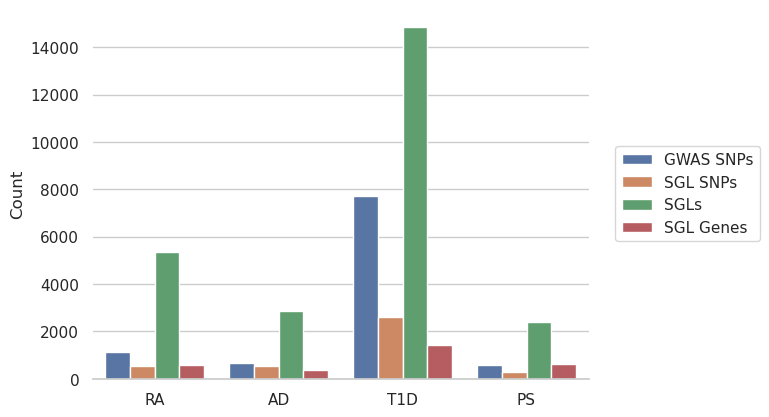

In [27]:
# extract data
plot_data = combine_uniq_mesh_counts.melt(ignore_index=False).reset_index()
plot_data.replace({'num_total_snps': 'GWAS SNPs', 'num_snps': 'SGL SNPs',
                    'num_genes': 'SGL Genes', 'num_sgls': 'SGLs',
                    'Arthritis, Rheumatoid': 'RA', 'Dermatitis, Atopic': 'AD',
                    'Diabetes Mellitus, Type 1': 'T1D', 'Psoriasis': 'PS'}, inplace=True)

# plot data
fig, ax = plt.subplots()

sns.barplot(plot_data, x='mesh_term', y='value', hue='variable', ax=ax)

# remove left spine
sns.despine(left=True)

# move legend
sns.move_legend(ax, "upper center", bbox_to_anchor=(1.2, 0.65))

# rotate X-Axis Ticks by 45-degrees
#ax.tick_params(axis='x', labelrotation = 75)

# set labels
ax.set_xlabel('')
ax.set_ylabel('Count')
legend = ax.legend_
legend.set_title('') 

outfn = os.path.join(outdir, 'sgl_breakdowns.png')
fig.savefig(outfn, dpi=600, bbox_inches='tight')

We can see that Type 1 Diabetes has the most number of SGLs. 

In [28]:
mesh_grps = all_df.groupby(['mesh_term'])

In [29]:
def get_top_counts(df, n=10):
    sorted_df = df.genename.value_counts().iloc[0:n]
    return(sorted_df)
mesh_grps.apply(get_top_counts)

mesh_term                  genename  
Arthritis, Rheumatoid      BRPF3          610
                           Z84485.1       610
                           FLOT1          574
                           IER3-AS1       574
                           IER3           574
                           ARID5B         547
                           HIST1H2AK      446
                           HIST1H2BN      446
                           HIST1H2BJ      411
                           HIST1H2AG      411
Dermatitis, Atopic         TRIB1          716
                           NFKBIA         480
                           MIR6090        431
                           ZBTB10         352
                           AC009812.1     352
                           AL662844.4     275
                           HCG27          275
                           ESYT1          245
                           RPL41          245
                           ZC3H10         245
Diabetes Mellitus, Type 1  APOBR         2

If we get the top SGLs based on genes we can see that gene such as NFKBIA are coming up.

In [30]:
cols = ['chrA_loop', 'startA_loop', 'endA_loop',
         'chrB_loop', 'startB_loop', 'endB_loop',
         '-log10_qval_loop', 'sample',
         'end_snp', 'snp_anchor', 
         'genename', 'geneid', 
         'mesh_term', 'author', 'causaldb_fn']

new_cols = ['ChrA', 'StartA', 'EndA',
             'ChrB', 'StartB', 'EndB',
             '-log10(Q values)', 'Sample Name',
             'SNP Pos', 'SNP Anchor', 
             'Gene Name', 'Gene ID', 
             'Mesh Term', 'Author', 'CAUSALdb Study ID']

# mesh_outfn = os.path.join(outdir, 'sgls.supplemental_table.xlsx')
# with pd.ExcelWriter(mesh_outfn) as fw:
#     for grp, grp_df in mesh_grps:
#         tdf = grp_df[cols].sort_values(['author', 'sample', 'chrA_loop', 'startA_loop', 'chrB_loop', 'startB_loop', 'end_snp', 'geneid'])
#         tdf.loc[:, 'chrA_loop'] = 'chr' + tdf.loc[:, 'chrA_loop'].astype(str)
#         tdf.loc[:, 'chrB_loop'] = 'chr' + tdf.loc[:, 'chrB_loop'].astype(str)
#         tdf.columns = new_cols
#         tdf.to_excel(fw, sheet_name=grp[0], index=False)

## Diving into SGLs for T1D

In [31]:
t1d_df = mesh_grps.get_group('Diabetes Mellitus, Type 1')

In [32]:
t1d_df.geneid.nunique()

1440

In [33]:
sgl_viz_cols = ['chrom', 'end_snp',
                'genename', 'geneid', 'start_gene', 'end_gene',
                'startA_loop', 'startB_loop', '-log10_qval_loop',
                'sample', 'author']
t1d_df.sort_values(['-log10_qval_loop', 'chrom', 'end_snp'], ascending=[False, True, True])[sgl_viz_cols].head(10)

,chrom,end_snp,genename,geneid,start_gene,end_gene,startA_loop,startB_loop,-log10_qval_loop,sample,author
44835,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,625.319750,THP-1-WT-Batch1.GSE149420.Homo_Sapiens.H3K4me3.b1,Forgetta V
44836,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,625.319750,THP-1-WT-Batch1.GSE149420.Homo_Sapiens.H3K4me3.b1,Forgetta V
45178,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,538.991056,THP-1-WT-Batch2.GSE149420.Homo_Sapiens.H3K4me3.b1,Forgetta V
45179,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,538.991056,THP-1-WT-Batch2.GSE149420.Homo_Sapiens.H3K4me3.b1,Forgetta V
87990,8,140637192,TRAPPC9,ENSG00000167632,140458578,140458579,140455000,140635000,445.600349,CD4_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,Chiou J
87989,8,140638981,TRAPPC9,ENSG00000167632,140458578,140458579,140455000,140635000,445.600349,CD4_Naive_All-Donors.phs001703v3p1.Homo_Sapien...,Chiou J
41585,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,432.843386,THP-1-del-cIDR-Batch1.GSE149420.Homo_Sapiens.H...,Forgetta V
41586,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,432.843386,THP-1-del-cIDR-Batch1.GSE149420.Homo_Sapiens.H...,Forgetta V
46895,13,91310826,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,401.119394,THP-1-Vector-Batch1.GSE149420.Homo_Sapiens.H3K...,Forgetta V
46896,13,91312880,MIR17HG,ENSG00000215417,91347819,91347820,91310000,91345000,401.119394,THP-1-Vector-Batch1.GSE149420.Homo_Sapiens.H3K...,Forgetta V


In [34]:
t1d_uniq_sgls = t1d_df.drop_duplicates(['chrA_loop', 'chrB_loop', 'startA_loop', 'startB_loop', 'geneid', 'start_snp'])

### Count and plot the number of sgls and snps per gene

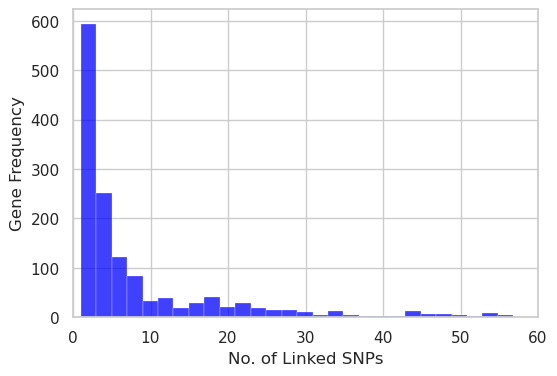

In [35]:
# getting the data
snps_per_gene = t1d_uniq_sgls.groupby('geneid').snp_pos.nunique().sort_values(ascending=False).reset_index()

# plotting
fig, ax = plt.subplots(figsize=(6,4))
sns.set_theme(style="whitegrid")
sns.histplot(snps_per_gene['snp_pos'], color='blue', binwidth=2, ax=ax, element='bars')

ax.set_xlim(0, 60)
ax.set_xlabel('No. of Linked SNPs')
ax.set_ylabel('Gene Frequency')
ax.set_title('')

outfn = os.path.join(outdir, 't1d_sgls.snps_per_gene.png')
fig.savefig(outfn, dpi=600, bbox_inches='tight')


In [36]:
snps_per_gene.snp_pos.describe()

count    1440.000000
mean       10.318750
std        18.730796
min         1.000000
25%         1.000000
50%         3.000000
75%        10.000000
max       316.000000
Name: snp_pos, dtype: float64

In [37]:
((snps_per_gene.snp_pos.value_counts() / len(snps_per_gene)) * 100).head(10)

snp_pos
1     26.527778
2     14.722222
3      9.027778
4      8.402778
6      4.930556
5      3.611111
7      3.263889
8      2.569444
17     1.597222
12     1.527778
Name: count, dtype: float64

In [38]:
# tdf = snps_per_gene.snp_pos.sort_values(ascending=True).to_frame()
# tdf['pos'] = list(range(tdf.shape[0]))
# tdf.columns = ['num_linked_snps', 'pos']

# # plotting
# fig, ax = plt.subplots(figsize=(6,4))
# sns.set_theme(style="whitegrid")
# sns.scatterplot(tdf, x='pos', y='num_linked_snps', s=10)

# #ax.set_xlim(0, 60)
# ax.set_xlabel('Gene')
# ax.set_ylabel('No. of Linked SNPs')
# ax.set_title('')
# #ax.set_xticklabels([])
# # outfn = os.path.join(outdir, 't1d_sgls.snps_per_gene.png')
# # fig.savefig(outfn, dpi=600, bbox_inches='tight')


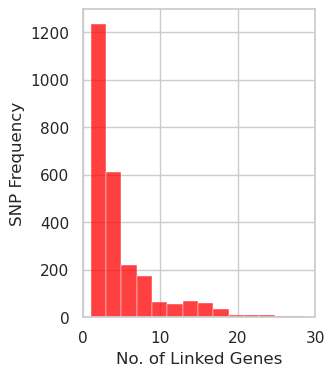

In [39]:
# getting the data
genes_per_snp = t1d_uniq_sgls.groupby('snp_pos').geneid.nunique().sort_values(ascending=False).reset_index()

# plotting
fig, ax = plt.subplots(figsize=(3,4))
sns.set_theme(style="whitegrid")
sns.histplot(genes_per_snp['geneid'], color='red', binwidth=2, ax=ax)

ax.set_xlim(0, 30)
ax.set_xlabel('No. of Linked Genes')
ax.set_ylabel('SNP Frequency')

outfn = os.path.join(outdir, 't1d_sgls.genes_per_snp.png')
fig.savefig(outfn, dpi=600, bbox_inches='tight')

In [40]:
genes_per_snp.geneid.describe()

count    2628.000000
mean        5.654110
std         9.778642
min         1.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       100.000000
Name: geneid, dtype: float64

In [41]:
((genes_per_snp.geneid.value_counts() / len(genes_per_snp)) * 100).head(10)

geneid
1     25.837139
2     21.156773
3     13.356164
4      9.855403
5      5.631659
7      3.691020
8      2.853881
6      2.663623
13     1.826484
9      1.445967
Name: count, dtype: float64

### Compare to the Consensus Gene List

In [42]:
def print_genelist(genelist):
    print('\n'.join(list(genelist)))

#### Save a list of unique genes for T1D

In [43]:
# get the uniq T1D SGL genes
uniq_genes = t1d_df.genename.unique()
print('The unique number of genes is: {}'.format(len(uniq_genes)))

The unique number of genes is: 1430


In [44]:
# save the SGL genes found for T1D
uniq_fn = os.path.join(outdir, 'uniq_genes.t1d.txt')
with open(uniq_fn, 'w') as fw:
    s = '\n'.join(sorted(uniq_genes))
    fw.write(s)

#### Load the consensus T1D gene list

In [45]:
t1d_consensus_list_fn = '/mnt/bioadhoc-temp/Groups/vd-ay/jreyna/projects/dchallenge/results/main/gene_lists/consensus_gene_list.txt'
t1d_consensus_genes = pd.read_table(t1d_consensus_list_fn, header=None, names=['genename'])
print('The number of consensus genes is: {}'.format(t1d_consensus_genes.shape[0]))

The number of consensus genes is: 497


In [46]:
'IL15' in t1d_consensus_genes.genename.tolist()

True

In [47]:
t1d_consensus_genes

,genename
0,APOB
1,PI4KA
2,PSMB8
3,AMBP
4,CD6
...,...
492,KLF3-AS1
493,CTRB2
494,CLN3
495,IL6R


#### Overlap the SGL genes with the consensus genes 

In [48]:
t1d_plus_consensus_df = t1d_df.loc[t1d_df.genename.isin(t1d_consensus_genes.iloc[:, 0].tolist())]

In [49]:
shared_t1d_plus_consensus_genes = sorted(t1d_plus_consensus_df.genename.unique().tolist())
print('The unique number of shared genes is: {}'.format(len(shared_t1d_plus_consensus_genes)))

The unique number of shared genes is: 103


In [50]:
all_t1d_genes = set(t1d_df.genename.tolist())

In [51]:
only_t1d_genes = all_t1d_genes.difference(shared_t1d_plus_consensus_genes)

In [52]:
# save the SGL genes found for T1D
uniq_fn = os.path.join(outdir, 'left_venn_only.uniq_genes.t1d.txt')
with open(uniq_fn, 'w') as fw:
    s = '\n'.join(sorted(only_t1d_genes))
    fw.write(s)

## Investigating Shared Genes

In [53]:
# extract protein coding genes and non-MT
prot_list = ['protein_coding', 'IG_V_gene', 'IG_C_gene', 'IG_J_gene',
             'TR_C_gene', 'TR_J_gene', 'TR_V_gene', 'TR_D_gene', 'IG_D_gene']
base_genes_df = gencode_df.loc[(gencode_df.genetype.isin(prot_list)) & (~gencode_df.chrom.isin(['chrM']))]

# get shared genes for T1D
shared_gene_df = base_genes_df.loc[base_genes_df.genename.isin(shared_t1d_plus_consensus_genes)]

# set associated sgls
shared_gene_sgls = t1d_df.loc[all_df.geneid.isin(shared_gene_df.geneid.tolist())]

# testing the removal of hist proteins
shared_gene_sgls = shared_gene_sgls.loc[~shared_gene_sgls.genename.str.contains('HIST')]

# add distance 
shared_gene_sgls.loc[:, 'distance'] = shared_gene_sgls.loc[:, 'startB_loop'] - shared_gene_sgls.loc[:, 'startA_loop']

In [54]:
shared_gene_sgls

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,chrom,start_snp,end_snp,...,end_gene,genename,geneid,strand,sample,mesh_term,author,filename,snp_pos,distance
0,12,111405000,111410000,12,111445000,111450000,10.659531,12,111446803,111446804,...,111405948,SH2B3,ENSG00000111252,+,Monocyte_1800-RH-1.phs001703v3p1.Homo_Sapiens....,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,12:111446804,40000
1,16,28490000,28495000,16,28535000,28540000,19.021164,16,28494338,28494339,...,28539174,NUPR1,ENSG00000176046,-,Monocyte_1800-RH-1.phs001703v3p1.Homo_Sapiens....,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,16:28494339,45000
21,6,90255000,90260000,6,90295000,90300000,7.353804,6,90255451,90255452,...,90296908,BACH2,ENSG00000112182,-,CD8_Naive_1829-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,6:90255452,40000
22,6,90265000,90270000,6,90295000,90300000,12.198553,6,90267048,90267049,...,90296908,BACH2,ENSG00000112182,-,CD8_Naive_1829-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,6:90267049,30000
23,6,90265000,90270000,6,90295000,90300000,12.198553,6,90268663,90268664,...,90296908,BACH2,ENSG00000112182,-,CD8_Naive_1829-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA266,6:90268664,30000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163366,6,90265000,90270000,6,90295000,90300000,23.943217,6,90267048,90267049,...,90296908,BACH2,ENSG00000112182,-,CD4_Naive_1831-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,6:90267049,30000
163376,17,39750000,39755000,17,39860000,39865000,25.413351,17,39754114,39754115,...,39864312,IKZF3,ENSG00000161405,-,CD4_Naive_1829-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,17:39754115,110000
163377,17,39750000,39755000,17,39860000,39865000,25.413351,17,39752613,39752614,...,39864312,IKZF3,ENSG00000161405,-,CD4_Naive_1829-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,17:39752614,110000
163378,17,40565000,40570000,17,40610000,40615000,12.928763,17,40614033,40614034,...,40565472,CCR7,ENSG00000126353,-,CD4_Naive_1829-RH-1.phs001703v3p1.Homo_Sapiens...,"Diabetes Mellitus, Type 1",Onengut Gumuscu S,CA265,17:40614034,45000


In [55]:
# calculating genes which are present in SGLs across more than 3 samples
shared_gene_freqs = shared_gene_sgls.drop_duplicates(['genename', 'sample']).genename.value_counts()
shared_genes_high_freq = shared_gene_freqs[shared_gene_freqs > 3]
shared_genes_high_freq_list = shared_genes_high_freq.index.tolist()

In [56]:
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100

check_genes = []
candidates = shared_gene_sgls.loc[shared_gene_sgls.distance > 200000].sort_values(['distance', 'genename'], ascending=[False, True])
candidates = candidates.loc[candidates.chr_gene != 6]
candidates = candidates.loc[~candidates.genename.isin(check_genes)]
candidates = candidates.loc[candidates.genename.isin(shared_genes_high_freq_list)]
candidates = candidates.loc[~candidates['sample'].str.startswith('THP-1')]

# display(candidates.iloc[:, 14:])
# #pd.options.display.max_rows = 200


In [57]:
candidates.genename.unique()

array(['RAD51B', 'IKZF3', 'CCR7', 'ITSN2', 'ATXN2L', 'NCOA1', 'CCRL2',
       'PSMB2', 'CCR5', 'SBK1'], dtype=object)

## Investigate Novel Genes

In [58]:
# extract protein coding genes and non-MT
prot_list = ['protein_coding', 'IG_V_gene', 'IG_C_gene', 'IG_J_gene',
             'TR_C_gene', 'TR_J_gene', 'TR_V_gene', 'TR_D_gene', 'IG_D_gene']
base_genes_df = gencode_df.loc[(gencode_df.genetype.isin(prot_list)) & (~gencode_df.chrom.isin(['chrM']))]

# get novel genes for T1D
novel_gene_df = base_genes_df.loc[base_genes_df.genename.isin(only_t1d_genes)]

# set associated sgls
novel_gene_sgls = t1d_df.loc[all_df.geneid.isin(novel_gene_df.geneid.tolist())]

# testing the removal of hist proteins
novel_gene_sgls = novel_gene_sgls.loc[~novel_gene_sgls.genename.str.contains('HIST')]

# add distance 
novel_gene_sgls.loc[:, 'distance'] = novel_gene_sgls.loc[:, 'startB_loop'] - novel_gene_sgls.loc[:, 'startA_loop']

In [59]:
#print(','.join(list(novel_gene_sgls.geneid.unique())))

In [60]:
# counting snp-gene pairs 
novel_gene_sgls.loc[:, 'sgname'] = novel_gene_sgls.loc[:, 'genename'] + ' & ' + novel_gene_sgls.loc[:, 'snp_pos']
sgpair_counts = novel_gene_sgls.sgname.value_counts().to_frame()

I'm interested in the frequency of each SNP + gene pair. Hopefully there is a pair with lots of samples. 

In [61]:
sgl_freqs = sgpair_counts.sort_index()['count'].unique()
sgl_freqs

array([  2,   1,  16,   5,   8,   4,   6,   9,   3,  30,  12,  18,  45,
        19,  10,  35,  14,  90,  36,  33,  52,  15,  20,  60,  48,  65,
        13,  26,  40,  80,  62,  29,  58,  87,  22, 208,   7,  23,  11,
        37,  24,  17,  21,  42,  27,  34,  28,  44,  43,  54,  25,  84,
        38,  57, 170,  68,  32,  70,  78,  75, 150,  39,  85, 115,  46,
       108, 102, 104, 312, 159,  56,  96])

In [62]:
pd.options.display.max_rows = 100
display(sgpair_counts)
pd.options.display.max_rows = 100

,count
sgname,
SGF29 & 16:28494339,312
APOBR & 16:28554837,208
APOBR & 16:28554346,208
AC138894.1 & 16:28554346,208
AC138894.1 & 16:28554837,208
...,...
CEP76 & 18:12821904,1
CEP76 & 18:12823057,1
CEP76 & 18:12821594,1


In [63]:
# calculating genes which are present in SGLs across more than 3 samples
novel_gene_freqs = novel_gene_sgls.drop_duplicates(['genename', 'sample']).genename.value_counts()
novel_genes_high_freq = novel_gene_freqs[novel_gene_freqs > 3]
novel_genes_high_freq_list = novel_genes_high_freq.index.tolist()

In [64]:
pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 1000
pd.options.display.max_columns = 100

check_genes = ['CD63', 'AC009779.2', 'AC073896.2', 'AC145285.3', 'SETD9', 'PUM3', 'AC022506.1', 'DDIT3', 'MBD6', 'PKNOX1', 'GPBP1']
check_genes += ['SLC30A1', 'ZBTB37', 'EIF1', 'CENPL', 'DARS2', 'ZFYVE26', 'KMT2E', 'NIPBL', 'BRIX1', 'RAD1', 'LONRF1']
check_genes += ['RAPGEF6', 'ITGB1', 'FAM210A', 'RNMT', 'DTL', 'INTS7', 'SIMM12', 'EPC1', 'SMIM12', 'NUDT6']
check_genes += ['RFX3', 'SPATA5', 'DUSP28', 'HSPA4', 'ZIC2', 'ANKMY1', 'RNPEPL1', 'ZSCAN22', 'FKBP1B']
check_genes += ['WDCP', 'SFPQ', 'CYP20A1', 'DOCK9', 'NCK1', 'FANCI', 'RRP1', 'STK40', 'AFG3L2']
check_genes += ['STAG1', 'NEK7', 'UBE2G2', 'RO60', 'DNAJC27', 'TNFSF4', 'ABHD2', 'IFT27', 'GDF9', 'UQCRQ']
check_genes += ['PRKAR1A', 'WIPI1', 'NCF4', 'TRAPPC10', 'PTRHD1', 'HAPLN3', 'HEXIM2', 'KIF14', 'UBAC2']
check_genes += ['GDF11', 'STARD3', 'SECISBP2', 'RARA', 'CCR1', 'CCR2', 'ORMDL2', 'SENP3', 'SENP3-EIF4A1']
candidates = novel_gene_sgls.loc[novel_gene_sgls.distance > 200000].sort_values(['distance', 'genename'], ascending=[False, True])
candidates = candidates.loc[candidates.chr_gene != 6]
candidates = candidates.loc[~candidates.genename.isin(check_genes)]
candidates = candidates.loc[candidates.genename.isin(novel_genes_high_freq_list)]
candidates = candidates.loc[~candidates['sample'].str.startswith('THP-1')]

#display(candidates.iloc[:, 14:])
#pd.options.display.max_rows = 200


In [65]:
for x in candidates.genename.unique():
    print(x)
    break

MTF1


In [66]:
nck1 = candidates.loc[candidates.genename == 'NCK1']
nck1

,chrA_loop,startA_loop,endA_loop,chrB_loop,startB_loop,endB_loop,-log10_qval_loop,chrom,start_snp,end_snp,rsid,maf,ea,nea,beta,se,p,zscore,paintor,caviarbf,finemap,meta_id,block_id,label,causaldb_fn,snp_anchor,chr_gene,start_gene,end_gene,genename,geneid,strand,sample,mesh_term,author,filename,snp_pos,distance,sgname


Unfortunately there are not. Initially I was trying to find an example where a SGL is found across many samples but this is just not found in the data. So I started to think, what else can I find or what other point can I make? For now, the point that I will try making is that we found a good SNP (or gene) which is found across many samples. 

I'll start with a good SNP, if I find one. 

In [68]:
# snp_counts = novel_gene_sgls.drop_duplicates(subset=['sample', 'snp_pos']) # want unique sample + snps
# snp_counts = snp_counts.groupby(by=['snp_pos']).count()['chrA_loop'] # counting the unique number of snps per sample 
# snp_counts = snp_counts.reset_index().rename(columns={'chrA_loop': 'count'}).sort_values(['count'], ascending=[True, False]) # cleaning + sorting
# snp_counts = snp_counts.pivot(index='snp_pos', columns='sample_grp', values='count', ) # pivoting for side-by-side analysis of grps
# snp_counts = snp_counts.fillna(0) # remove NaN's
# snp_counts = snp_counts.astype(int) # convert to ints
# snp_counts.loc[:, 'sum'] = snp_counts.iloc[:, 0:6].sum(axis=1) # add row sum
# snp_counts.loc[:, 'max'] = snp_counts.iloc[:, 0:6].max(axis=1) # add row max

# # add the mb location
# def get_mb(x):
#     spl = x.split(':')
#     res = spl[0] + ':' + spl[1][0:2]
#     return(res)
# snp_counts['chr_mb'] = [get_mb(x)for x in snp_counts.index.values]

# # filter based on the max
# snp_counts_flt = snp_counts.loc[snp_counts['max'] > 2].sort_values(['chr_mb', 'max'], ascending=[True, False])

# snp_counts_flt = snp_counts_flt.reset_index().set_index(['chr_mb', 'snp_pos']) # creating multi-index with chr_mb

In [71]:

# # highlight based on the max
# def highlight_max(data, color='yellow'):
#     '''
#     highlight the maximum in a Series or DataFrame
#     '''
#     attr = 'background-color: {}'.format(color)
#     if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
#         is_gte_thresh = data > 3
#         return [attr if v else '' for v in is_gte_thresh]
#     else:  # from .apply(axis=None)
#         is_gte_thresh = data > 3
#         return pd.DataFrame(np.where(is_max, attr, ''),
#                             index=data.index, columns=data.columns)

# snp_counts_flt.style.apply(highlight_max, subset=['max'])

In [72]:
novel_gene_sgls.loc[(novel_gene_sgls.snp_pos.str.contains('^11:64'))]['genename']

62573       TRMT112
62574         PRDX5
62575       TRMT112
62576         PRDX5
62577       TRMT112
62578         PRDX5
63060       TRMT112
63061         PRDX5
63062       TRMT112
63063         PRDX5
63064       TRMT112
63065         PRDX5
63066       TRMT112
63067         PRDX5
63765         STIP1
63766         STIP1
63767         STIP1
63768         STIP1
63769         STIP1
63770         STIP1
63771         STIP1
63772        FERMT3
63773        FERMT3
63774        FERMT3
63775        FERMT3
63776        FERMT3
63777        FERMT3
63778        FERMT3
63779        NUDT22
63780         TRPT1
63781        NUDT22
63782         TRPT1
63783        NUDT22
63784         TRPT1
63785        NUDT22
63786         TRPT1
63787         FKBP2
63788    AP001453.5
63789         FKBP2
63790    AP001453.5
63791         FKBP2
63792    AP001453.5
63793         FKBP2
63794    AP001453.5
63795        GPR137
63796      CATSPERZ
63797      CATSPERZ
63798      CATSPERZ
63799      CATSPERZ
63800       TRMT112


#### Perform Mann-Whitney Test Between GWAS Catalog & SGL Distributions

In [73]:
# preprocess the GWAS data first
pd.set_option('display.max_columns', None)

# loading GWAS Catalog data
gc_data = pd.read_table('results/hg38/external_studies/gwas_catalog/gwas_catalog_v1.0-associations_e112_r2024-07-27.tsv')

# extract genome-wide significance values
gc_data.loc[gc_data.loc[:, 'P-VALUE'] < 5*10**(-8)]

# dropping duplicate values
gc_data = gc_data.loc[gc_data.duplicated(['CHR_ID', 'CHR_POS'], keep='first')]

# drop 
gc_data = gc_data.loc[~gc_data['CHR_POS'].isna()]

# getting just the bed information
gc_data = gc_data.iloc[:, [11,12]]

# remove those that cannot be converted
def can_convert_to_int(x):
    try:
        int(x)
        return(True)
    except:
        return(False)
gc_data = gc_data.loc[gc_data['CHR_POS'].apply(can_convert_to_int)]

# convert to int
gc_data.loc[:, 'CHR_POS'] = gc_data['CHR_POS'].astype(int)


# rename and reorder
gc_data.rename(columns={'CHR_ID': 'chrom', 'CHR_POS': 'end'}, inplace=True)
gc_data['start'] = gc_data['end'] - 1
gc_data = gc_data.iloc[:, [0,2,1]]

# add chr
gc_data['chrom'] = 'chr' + gc_data['chrom']

# add 1mb to start and end
# gc_data.iloc[:, 1] = gc_data.iloc[:, 1].apply(lambda x: max(0, x - 1000000))
# gc_data.iloc[:, 2] = gc_data.iloc[:, 2] + 1000000
gc_data.iloc[:, 1] = gc_data.iloc[:, 1].apply(lambda x: max(0, x - 100000))
gc_data.iloc[:, 2] = gc_data.iloc[:, 2] + 100000

# sort
gc_data.sort_values(['chrom', 'start'], inplace=True)

/mnt/BioHome/jreyna/tmp/ipykernel_3760992/4155706276.py:5: DtypeWarning: Columns (12,13,23) have mixed types. Specify dtype option on import or set low_memory=False.
  gc_data = pd.read_table('results/hg38/external_studies/gwas_catalog/gwas_catalog_v1.0-associations_e112_r2024-07-27.tsv')


In [74]:
# intersect the SNPs with genes
gc_pbt = pbt.BedTool.from_dataframe(gc_data)
gencode_prots = gencode_df.loc[gencode_df['genetype'] == 'protein_coding']
gene_pbt = pbt.BedTool.from_dataframe(gencode_prots.iloc[:, [0,1,2,5]])

# map the genes to SNPs
gc_with_genes = gc_pbt.map(gene_pbt, c='4', o='count_distinct')
gc_with_genes_df = gc_with_genes.to_dataframe(header=None, disable_auto_names=True)
gc_with_genes_df = gc_with_genes_df.drop_duplicates(subset=[0,1,2,3])

# remove entries without a gene
gc_with_genes_df = gc_with_genes_df.loc[gc_with_genes_df.iloc[:, 3] != '.']
gc_with_genes_df.iloc[:, 3] = gc_with_genes_df.iloc[:, 3].astype(int)

<Axes: ylabel='Frequency'>

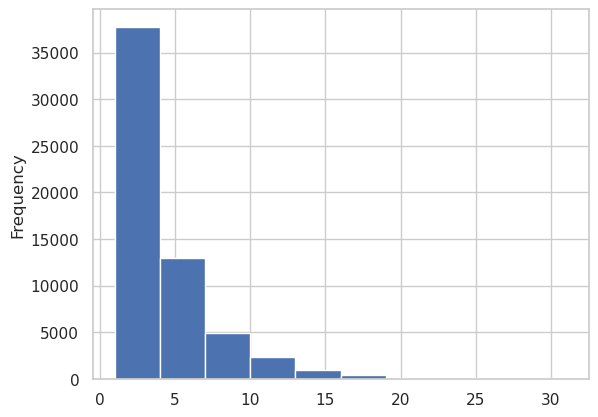

In [75]:
gc_with_genes_df.iloc[:, 3].plot(kind='hist')

In [77]:
def calculate_mannwhitenyu(dataA, dataB):

    # Step 1: Calculate medians
    median_A = np.median(data_A)
    median_B = np.median(data_B)

    # Step 2: Perform the Mann-Whitney U test
    # The test checks if the distribution of one sample is shifted relative to another
    statistic, p_value = mannwhitneyu(data_B, data_A, alternative='less')
    
    # return tuple result
    mw_ntuple = namedtuple('mw', ['median_A', 'median_B', 'statistic', 'p_value'])
    mw_result = mw_ntuple(median_A, median_B, statistic, p_value)
    return(mw_result)
    
    
def summarize_mannwhitenyu(result):

    # Print the results
    print(f"Median of A: {result.median_A}")
    print(f"Median of B: {result.median_B}")

    print(f"Mann-Whitney U statistic: {result.statistic}")
    print(f"P-value: {result.p_value}")

    # Interpretation
    alpha = 0.05  # Significance level
    if result.p_value < alpha:
        print("Reject the null hypothesis: The median of B is significantly smaller than the median of A.")
    else:
        print("Fail to reject the null hypothesis: There is no significant evidence that the median of B is smaller than the median of A.")
        
# Sample data (replace with your actual data)
data_A = np.array(gc_with_genes_df.iloc[:, 3].astype(int))  # Replace with your data for list A
data_B = np.array(genes_per_snp.geneid.astype(int))  # Replace with your data for list B

mw_genes = calculate_mannwhitenyu(data_A, data_B)
summarize_mannwhitenyu(mw_genes)

Median of A: 3.0
Median of B: 3.0
Mann-Whitney U statistic: 83328853.5
P-value: 0.9999999757330542
Fail to reject the null hypothesis: There is no significant evidence that the median of B is smaller than the median of A.


In [78]:
gc_with_genes_df

,0,1,2,3
0,chr1,860325,1060326,8
2,chr1,879471,1079472,9
3,chr1,899841,1099842,10
5,chr1,913489,1113490,10
7,chr1,923524,1123525,10
...,...,...,...,...
252858,chrX,155095892,155295893,5
252859,chrX,155233587,155433588,5
252860,chrX,155575418,155775419,2
252865,chrX,155657484,155857485,2


In [79]:
# making gc data with an id for mapping
gc_extra_data = gc_data.copy()
gc_extra_data['id'] = gc_extra_data['chrom'] + ':'  + gc_extra_data['start'].astype(str) + '-' + gc_extra_data['end'].astype(str)
gc_extra_pbt = pbt.BedTool.from_dataframe(gc_extra_data)

# map the genes to SNPs
gc_with_snps = gene_pbt.map(gc_extra_pbt, c='4', o='count_distinct')
gc_with_snps_df = gc_with_snps.to_dataframe(header=None, disable_auto_names=True)
gc_with_snps_df = gc_with_snps_df.drop_duplicates(subset=[0,1,2,3])

# remove entries without a gene
gc_with_snps_df = gc_with_snps_df.loc[gc_with_snps_df.iloc[:, 4] != '.']
gc_with_snps_df.iloc[:, 4] = gc_with_snps_df.iloc[:, 4].astype(int)


In [80]:
gc_with_snps_df

,0,1,2,3,4
3,chr1,923927,944581,ENSG00000187634,6
4,chr1,944202,959309,ENSG00000188976,8
5,chr1,960583,965719,ENSG00000187961,8
6,chr1,966496,975865,ENSG00000187583,8
7,chr1,975203,982093,ENSG00000187642,8
...,...,...,...,...,...
19913,chrX,155380786,155381134,ENSG00000277858,1
19914,chrX,155382114,155383230,ENSG00000274791,1
19917,chrX,155489010,155669944,ENSG00000185973,2
19918,chrX,155767811,155782459,ENSG00000168939,2


In [82]:
# Sample data (replace with your actual data)
data_A = np.array(gc_with_snps_df.iloc[:, 4].astype(int))  # Replace with your data for list A
data_B = np.array(snps_per_gene.snp_pos.astype(int))  # Replace with your data for list B

mw_genes = calculate_mannwhitenyu(data_A, data_B)
summarize_mannwhitenyu(mw_genes)

Median of A: 7.0
Median of B: 3.0
Mann-Whitney U statistic: 9530943.5
P-value: 2.5839201942154205e-61
Reject the null hypothesis: The median of B is significantly smaller than the median of A.
